# Generic Data Source
## Processing and Figure Production Template

A template workflow for the analysis of federal funding information (namely grant records) for open-science-related endeavors.

### Overview

This notebook is designed to make use of the [code toolset]() provided with this repository and, in doing so, apply a customized data acquisition and processing workflow on your local system (which is presumed to not have the requisite data files--at least not the first time you run this notebook).  Once this data has been acquired and processed, some standard analyses are conducted and associated figures are generated.

#### A warning

Each of the workflow steps (e.g. acquisition, preprocessing, analysis, figure generation) takes a nontrivial amount of local storage space (e.g. 150 GB in the case of NIH data) and a nontrivial amount of processing time.  Be aware of this as you seek to enact this notebook.

### File paths and assumptions

We'll start by establishing a number of parameters and filepaths that will be used throughout this process.  **Be sure to inspect these to ensure that they are consistent with your local setup before proceeding**

In [ ]:
import os
# we're going to assume that this notebook is being run from the /notebooks directory of the repository
# if this is not the case then you will need to adjust the path to the /inputData directory, which should be in the same directory as the /notebooks directory
inputDataDir='..' + os.sep + 'inputData' + os.sep

# relatedly, we will also need to make extensive use of code that has been developed for this project.
# this code is stored within the /src directory of the repository
codeDir='..' + os.sep + 'src' + os.sep
# we will need to add this code directory to the python path so that we can import the code
import sys
sys.path.append(codeDir)
import analyzeData
import getData
import processData
import figs

# within the inputDataDir, there could conceivably be a data directory for each of the potential data sources that this toolset was designed to work with
# these include: grants.gov, NIH, NSF, and USAspending
dataSources=['grantsGov','NIH','NSF','USAspending']
# inside each of these data source directories, there should be a set of sub-directories corresponding to various phases of the workflow.  These are:
dataFolders=['raw','processed','analyzed','figures']
# the raw directory should contain the raw data files as downloaded from the data source
# the processed directory should contain the data files after they have been processed by the appropriate data processing functions for that data set
# the analyzed directory should contain the data derivitives of standard analysis functions
# the figures directory should contain the figures depicting the results of the various analyses

# for now though we must select a single data source.  For the purposes of this template, we wil default to the first exemplar in the dataSources list, which is grants.gov
defaultDataSource=dataSources[0]

# additionally, one of the main goals / analyses of this project is to identify which funding records correspond to open-science endeavors
# The first-pass approach for this is to use a set of keywords as search targets within descriptions of the funding records.
# However several such keyword lists have been developed for this project.  These include:
keyWordOptions=['keywords.csv','OSterms_LeeChung2022.csv','GPT_OS-Terms.csv']
# as you may have surmised, each of these is a csv file containing a list of keywords.  The last column are the keywords themselves, while any preceeding colums correspond to higher-order categories that the keywords may be grouped into
# for now though we must select a single keyword list.  For the purposes of this template, we wil default to the second exemplar in the keyWordOptions list, which is OSterms_LeeChung2022.csv
defaultKeyWordList=keyWordOptions[1]

### Data acquisition

Each of the established data sources has an online repository which can be used to download the entirety of the corresponding data.  However, these are not standardized, and so it is necessary to use a custom created set of functions to download the corresponding data.  That is what we will do in the next section.

In order to ensure that we aren't wasting effort though, we'll be sure to check if there is already data in the 'raw' directory.  If so, we'll skip the downloading and proceed to the pre-processing phase.

**NOTE**: If it is necessary to download the data, this may take a particularly long time.  Additionally, depending on the data provider, it may be necessary to re-initiate the download process more than once to ensure a complete download of the dataset

In [ ]:
from glob import glob
# first we set the path to the raw data directory for the selected data source
currentRawDataDir=os.path.join(inputDataDir,defaultDataSource,dataFolders[0])
# let's see if the directory exists and if so, if there are at least one compressed file (e.g. .zip, .gz, .tar, etc.) and one xml file (which would presumably be the uncompressed, and unprocessed data)
# if not, then we will need to download the data from the data source
rawDirContainsCompressed=glob(currentRawDataDir + os.sep + ['*.zip','*.gz','*.tar'])
rawDirContainsXML=glob(currentRawDataDir + os.sep + '*.xml')
# if we fail to find at least one compressed file or one xml file, then we will need to download the data from the data source
if (len(rawDirContainsCompressed)==0) or (len(rawDirContainsXML)==0):
    print('Search of raw data directory\n' + currentRawDataDir + '\n failed to find at least one compressed file and one xml file.  Downloading data from data source.')
    getData.getDataFromRemoteSource(currentRawDataDir,defaultDataSource)


### Data processing

Assuming the data has been downloaded successfully, it now needs to be processed.

As before we can check to see if this has already been done.  If not, this may take a while.

In [ ]:
# first set the path to the processed data directory for the selected data source
currentProcessedDataDir=os.path.join(inputDataDir,defaultDataSource,dataFolders[1])
# let's see if the directory exists and if so, if there are at least one xml file.  In reality, if processing has occured there should be thousands.
# if not, then we will need to process the data from the raw data
processedDirContainsXML=glob(currentProcessedDataDir + os.sep + '*.xml')
# if we fail to find at least one xml file, then we will need to process the data from the raw data
if (len(processedDirContainsXML)==0):
    print('Search of processed data directory\n' + currentProcessedDataDir + '\n failed to find at least one xml file.  Processing data from raw data.')
    processData.processDownloadedData(currentRawDataDir,defaultDataSource,currentProcessedDataDir,singleMulti='multi')

In [ ]:
from bs4 import BeautifulSoup
import xmltodict
import sys
import os
import pandas as pd
import glob

# import our helper functions
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
sys.path

#import the grantsGov_utilities modules
import analyzeData
import daskFuncs
import getData
import processData


# local data storage directory
localDataDir='../inputData'
# convert this to the absolute path
localDataDir=os.path.abspath(localDataDir)

# use the getData module to download the data from grants.gov
dataPath=getData.getDataFromRemoteSource(localDataDir,'grantsGov')
# print the contents of the dataPath.  If it's a file print it's size and type, if it's a directory print the first 100 file names
if os.path.isfile(dataPath):
    print(os.stat(dataPath))
else:
    print(os.listdir(dataPath)[0:100])

Searching for data in /media/dan/HD4/coding/gitDir/USG_grants_crawl/inputData/grantsGov...
The grants.gov data has already been downloaded.  No need to re-download.
The file is located at /media/dan/HD4/coding/gitDir/USG_grants_crawl/inputData/grantsGov/GrantsDBExtract20230623v2.xml.
os.stat_result(st_mode=33188, st_ino=1528514, st_dev=2096, st_nlink=1, st_uid=1000, st_gid=1000, st_size=280182858, st_atime=1687551742, st_mtime=1687551743, st_ctime=1687551743)


## Cleaning
As we noted in the previous chapter, we need to do a bit of cleaning, so lets do a more comprehensive version of that here.

Note:  This may take a moment

In [ ]:
#processData.processDownloadedData(dataPath,'grantsGov',singleMulti='multi')
# the resultant data should be stored in the grantsGov/processed directory
processedDataPath=os.path.join(localDataDir,'grantsGov','processed')

### How do we find "Open Science Infrastructure"-related grants?

How can we tell which of these grants are related to-Open Science Infrastructure?  The `Description` field of the grant records contained in the database provide a potential target for filtering the grants.  If we can find a way to use the information contained within the description to determine whether or not the grant is related to this topic, we might be able to limit our consideration to this subset, and thereby be able to make insights about its characteristics.

Before we dive too deeply into using the `Description` it may be best for us to perform a sanity check and see how much information is contained within this field across the various grant entries. For this approach to be viable, a sufficient number of the grant descriptions will need to have a reasonable amount of text.

In [ ]:
import h5py

# set the path to the list of terms to search for
currenthSearchList='OSterms_LeeChung2022'
searchTermsPath="../" + currenthSearchList + '.csv'
searchTermsPath=os.path.abspath(searchTermsPath)
# read in the search terms
searchTerms=pd.read_csv(searchTermsPath)
# in the case of any of the current keyword files:
# LeeChung2022, GPT_OS-Terms, keywords
# we have to use the *last* column of the csv file as our search terms (as a list of strings)
stringPhraseList=searchTerms.iloc[:,-1].tolist()
# we also need to lemmatize each of these
# it does this in the function
#for i in range(len(stringPhraseList)):
#    stringPhraseList[i]=analyzeData.prepareTextForNLP(stringPhraseList[i])
# for grantsGov we are using "Description" field, no need for list because the "Description" field is at the top of the xml structure.
fieldsSelect=['rootTag','Description']

# perform the search and save the results to a file
# this will take a while
# set savePath
savePath=os.path.join(localDataDir,'grantsGov','processed',currenthSearchList + '_results.h5')
analyzeData.regexSearchAndSave(processedDataPath,stringPhraseList,fieldsSelect,savePath=savePath)
# also take this opportunity to get the departments / agencies
agencyField=['rootTag','AgencyCode']
# get a list of the xml contents of the processedDataPath directory
inputStructs=os.listdir(processedDataPath)
# filter this down to the xml files
inputStructs=[x for x in inputStructs if x.endswith('.xml')]
# create full paths for all of these
inputStructs=[os.path.join(processedDataPath,x) for x in inputStructs]
# set the save path
savePath=os.path.join(localDataDir,'grantsGov','processed','grantsGov_agencies.csv')
analyzeData.fieldExtractAndSave(inputStructs,agencyField,nameField='infer',savePath=savePath)

Searching for the string phrase: replication crisis
Searching for the string phrase: methodology
Searching for the string phrase: preregistration
Searching for the string phrase: replication
Searching for the string phrase: registered reports
Searching for the string phrase: preprints
Searching for the string phrase: social sciences
Searching for the string phrase: reproducibility
Searching for the string phrase: transparency
Searching for the string phrase: replicability
Searching for the string phrase: COVID-19
Searching for the string phrase: ethics
Searching for the string phrase: journal policy
Searching for the string phrase: meta-analysis
Searching for the string phrase: meta-research
Searching for the string phrase: meta-science
Searching for the string phrase: policies
Searching for the string phrase: research methods
Searching for the string phrase: open access
Searching for the string phrase: scholarly communication
Searching for the string phrase: collaboration
Searching fo

In [ ]:
# now we want to plot the results using seaborn
# start by loading the hdf5 file with the results
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
# recall this is how we set the path previously
hd5Path=os.path.join(localDataDir,'grantsGov','processed',currenthSearchList + '_results.h5')
# load the file
saveDictionary=h5py.File(hd5Path,'r')

# also load the agencies
#hd5Path=os.path.join(localDataDir,'grantsGov','processed','grantsGov_agencies.h5')\
# load the file
#agencyDictionary=h5py.File(hd5Path,'r')
# NOTE actually we changed this, because a 2D matrix is super inefficient when each row / grant can only have a single agency
# as such we are now using a csv file
agencyPath=os.path.join(localDataDir,'grantsGov','processed','grantsGov_agencies.csv')
agencyDictionary=pd.read_csv(agencyPath)


# we'll produce a bar plot where the x axis is the number of term matches in a given grant, and the y axis is the number of grants with that number of term matches
# additionally, we'll color subsections of the bars by the agency
# we'll start by getting the list of agencies
# this is a list of strings
agencyList=np.unique(agencyDictionary['fieldValue'].tolist())
# next create a mapping for the colors
# we'll use the seaborn color palette
# first get the number of agencies
numAgencies=len(agencyList)
# then get the color palette
colorPalette=sns.color_palette("hls", numAgencies)

# next we need to ensure that the data structure can be plotted as a stacked bar plot
# we'll start by counting the number of term matches for each grant
# this is a vector of integers
termMatchCounts=np.count_nonzero(saveDictionary['dataMatrix'],axis=0)
# lets create a pandas dataframe to hold the data we will plot
# the rows will correspond to the number of term matches, while the columns will correspond to the agencies
# we'll start by getting the maximum number of term matches
maxTermMatches=np.max(termMatchCounts)
# next we'll create a pandas dataframe with, where the column names come from agencyList
# and the row names come from the number of term matches
# we'll initialize the dataframe with zeros
plotData=pd.DataFrame(np.zeros((maxTermMatches,numAgencies)),columns=agencyList)
# next we also need to make sure that the entries in agencyDictionary['itemID']
# are in the same order as the the columns / grants in saveDictionary['dataMatrix']
# the specific grantIDs for saveDictionary are found in saveDictionary['colName']
# we'll start by getting the grantIDs from saveDictionary
# hopefully these are strings and not bytes
grantIDs=saveDictionary['colName'][:]
# if the first entry is a byte, we'll convert all of them to strings
if type(grantIDs[0])==bytes:
    grantIDs=[x.decode('utf-8') for x in grantIDs]
    
# next we'll get the grantIDs from agencyDictionary
agencyGrantIDs=agencyDictionary['itemID'].tolist()
# we'll do a quick check to make sure that the two lists are the same
if not grantIDs==agencyGrantIDs:
    # if they are not the same, we'll need to reorder the rows of agencyDictionary
    # we'll start by getting the indices that would sort grantIDs
    sortIndices=np.argsort(grantIDs)
    # then we'll get the indices that would sort agencyGrantIDs
    agencySortIndices=np.argsort(agencyGrantIDs)
    # then we'll chain these to get the indices that would sort agencyDictionary to the same order as saveDictionary
    correctSortIndices=np.argsort(agencySortIndices[sortIndices])
    # then we'll use these indices to reorder agencyDictionary
    agencyDictionary=agencyDictionary[correctSortIndices,:]
# NOTE: Maybe none of this is necessary


# next we'll iterate over the agencies 
for i in range(numAgencies):
    # set the current agency
    currentAgency=agencyList[i]
    # get the indices of in the values in agencyDictionary['fieldValue'] that match currentAgency
    currentIndices=np.where(agencyDictionary['fieldValue'][0,:]==currentAgency)[0]
    # use these indicies on agencyDictionary['itemID'] to get the grantIDs
    currentGrantIDs=agencyDictionary['itemID'][0,currentIndices]
    # then use these grantIDs to get the indices of the grants in saveDictionary['colName']
    currentAgencyGrantIndices=[grantIDs.index(x) for x in currentGrantIDs]
    # then use these indices to get the number of term matches for the grants
    currentTermMatchCounts=termMatchCounts[currentAgencyGrantIndices]
    # then iterate over the range between 0 and maxTermMatches and fill in the associated rows of plotData with the counts
    for j in range(0,maxTermMatches+1):
        # check to see if j is even in currentTermMatchCounts
        if j in currentTermMatchCounts:
            # if it is, then get the number of times it occurs
            currentCount=np.count_nonzero(currentTermMatchCounts==j)
            # then set the corresponding entry in plotData to this count
            plotData[currentAgency][j]=currentCount

# now we can plot the data

# set the seaborn style
sns.set(style="whitegrid")
# set the figure size
plt.figure(figsize=(10, 6))
# set the x axis label
plt.xlabel('Number of term matches')
# set the y axis label
plt.ylabel('Number of grants')
# set the title
plt.title('Number of term matches per grant')

# we'll use an iterative approach to plot the data
# this will require a bit of trickery, but we shold be fine
# we'll iterate over the agencies
# but first we need to create a vector to store the total count of grants for each count number, it will start as a vector of zeros
totalCount=np.zeros(maxTermMatches+1)
# then we'll iterate over the agencies
for i in range(numAgencies):
    # set the current agency
    currentAgency=agencyList[i]
    # set the current color
    currentColor=colorPalette[i]
    # create a temporary dataframe with the current agency, where the are two columns, 
    # the first simply has the number of term matches, and the second has the number of grants with that number of term matches
    tempData=pd.DataFrame({'termMatches':plotData[currentAgency].index,'grantCount':plotData[currentAgency].values})
    # BEFORE WE PLOT THOUGH
    # we need to recompute and reset the grant counts, to account for the fact that we are plotting a stacked bar plot
    # we'll start by getting the grant counts
    currentGrantCounts=tempData['grantCount'].values
    # then we'll add them to the totalCount
    totalCount=totalCount+currentGrantCounts
    # then we'll set the grant counts to the totalCount
    tempData['grantCount']=totalCount
    # then we'll plot the data
    plt.bar(tempData['termMatches'],tempData['grantCount'],color=currentColor,label=currentAgency)

# then we'll add the legend
plt.legend(loc='upper right')
# then we'll save the figure
plt.savefig(os.path.join(localDataDir,'grantsGov','figures','termMatchCounts.png'))





InvalidIndexError: (array([34238,  9830, 20745, ..., 70924, 33683, 44305]), slice(None, None, None))

In [ ]:
saveDictionary['colName'][:]

array([b'54801.xml', b'269408.xml', b'313139.xml', ..., b'282128.xml',
       b'266576.xml', b'323977.xml'], dtype=object)

In [ ]:
np.unique(countsList)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.])

#### With a simple keyword search

We can make a first, naieve attempt at this by using a word-bank with words or phrases that we believe are likely to show up in a grant relevant to open science infrastructure (e.g. 'metadata', 'FAIR', 'data sharing', etc.).  In this repository we have just such a word-bank already available (in `keywords.txt`), but users should feel free to update and/or augment it as they see fit.

To begin then, we'll do a quick search to see how many grants each of the word-bank terms comes up in.

In [ ]:
import json
import seaborn as sns
import itertools
import pandas as pd
import matplotlib.pyplot as plt


# open the keywords file
with open('../keywords.txt', 'r') as f:
    keywords = f.read()

# split it into a list.  Each term is kept on a separate line
keywords=keywords.split('\n')

# create a dictionary which will be saved as a json, so that you don't have to do this each time
grantFindsOut={}

# iterate through the keywords
for iKeywords in keywords:
    # create a blank list to store the IDs of the grants with the keyword in the description
    grantsFound=[]
    compiledSearch=re.compile('\\b'+iKeywords.lower()+'\\b')
    for iRow,iListing in grantsDF.iterrows():
        # maybe it doesn't have a description field
        try:
            # case insensitive find for the keyword
            if bool(compiledSearch.search(iListing['Description'].lower().replace('-',''))):
                #append the ID if found
                grantsFound.append(iListing['OpportunityID'])
        except:
            # do nothing, if there's no description field, then the word can't be found
            pass
            
    # store the found entries in the output dictionary.  Use the keyword as the key (with spaces replaced with underscores),
    # and the value being the list of grant IDs
    grantFindsOut[iKeywords.replace(' ','_')]=grantsFound

# save it out
with open("grantFindsOut.json", "w") as outfile:
    json.dump(grantFindsOut, outfile)
    
# plot a histogram
#silly way to do this, but seaborn was giving me issues
import itertools
keywordCountVec=[]
for iKeywords in list(grantFindsOut.keys()):
    currVec=[iKeywords.replace('_','\n')] * len(grantFindsOut[iKeywords])
    keywordCountVec.extend(currVec)

import seaborn as sns
keywordHistDF=pd.DataFrame(data=keywordCountVec, columns=['keyword'])
#keywordHistDF.loc[0:10]=[len(grantFindsOut[iKeyword]) for iKeyword in grantFindsOut.keys()]
#keywordHistDF
sns.set(rc={'figure.figsize':(25,10)})
ax=sns.countplot(keywordCountVec)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right",rotation_mode='anchor',fontsize=18, linespacing=.8)
#ax.set_yticklabels(ax.get_yticklabels(),fontsize=20)
ax.tick_params(axis='both', which='major', pad=0)
plt.tight_layout()
plt.show()

NameError: name 're' is not defined

#### The resulting plot

In the resulting plot we get a rough sense of how frequently these terms are coming up.  Admittedly, we don't actually know the context in which these terms are being used, so it's quite possible that they are being used with a different meaning in mind (e.g. "fair").  That being said, it's a only starting point, and maybe we can do better.

### Co-occurance

Perhaps it's not sufficient to know if _any_ of the relevant terms shows up in the gant description.  Maybe instead, we might want to require some number or subset of these terms to co-occur to help ensure that we're actually targeting relevant grants.  To consider this, we would want to look at which of these terms occur together and how frequently they do so.

Lets start with a basic matrix plot of these relations.

Text(0.5, 1.0, 'Open science term co-occurrences')

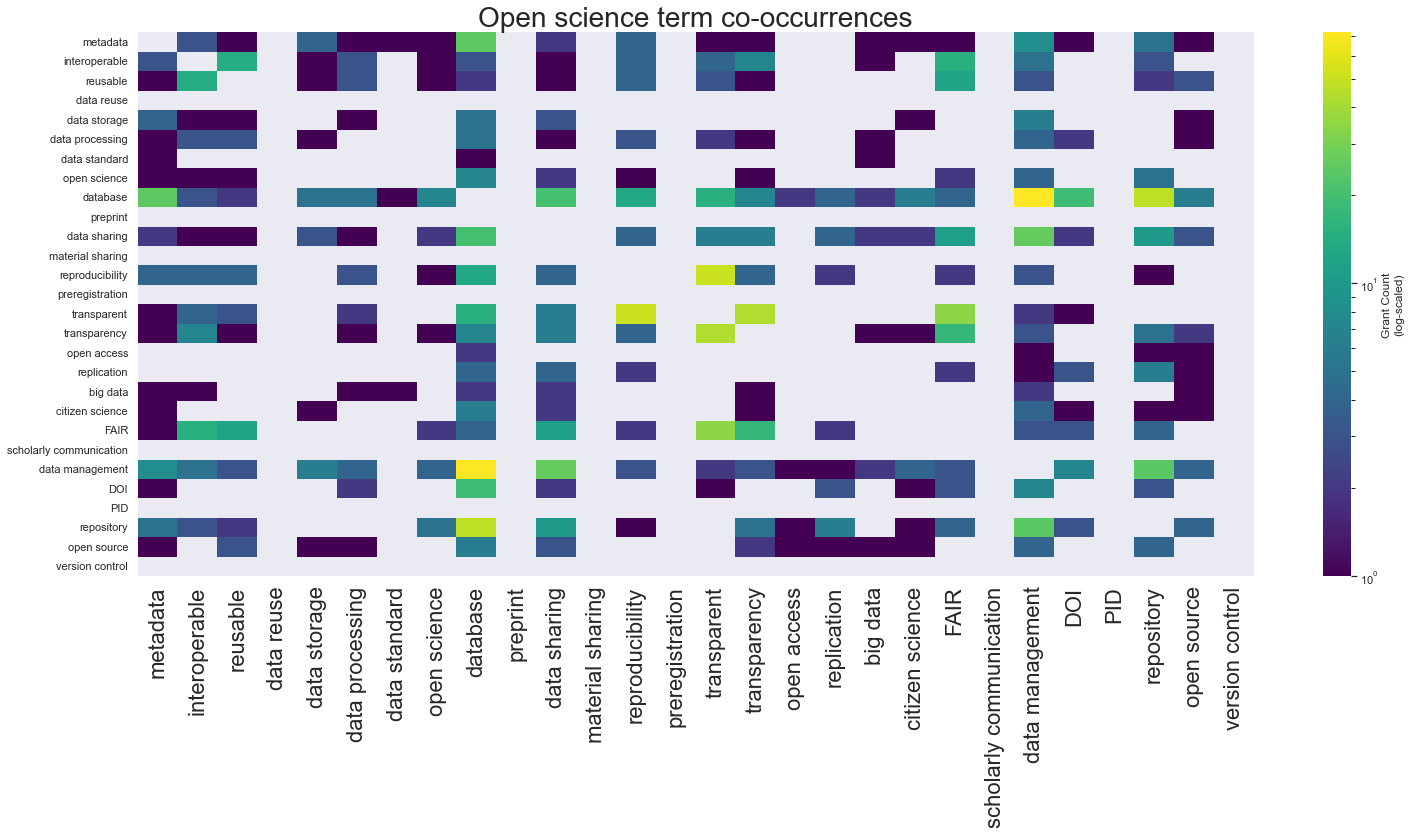

In [ ]:
import numpy as np
import copy
from matplotlib.colors import LogNorm
# ok, lets create a matrix that holds co-occurance data
# let's start by making a blank matrix to hold the data
connectivityMatrix=np.zeros((len(keywords),len(keywords)), dtype=np.int32())
# also make a list to hold the rows from this
dfRowContentAll=[]
# should be symmetric so x and y doesn't really matter
# use this opportunity to get the indexes of the lower triangle though
lowerTriIndices = [list(x) for x in np.tril_indices_from(connectivityMatrix)]
#convert this to the format we need
lowerTriList=[[lowerTriIndices[0][iIndex],lowerTriIndices[1][iIndex]] for iIndex in range(len(lowerTriIndices[0]))]
# iterate across both axes

for iIndexX, iKeywordsX in enumerate(keywords):
    for iIndexY, iKeywordsY in enumerate(keywords):
        # get the values for each "node" (e.g. the grant IDs for each keyword)
        IDsX=grantFindsOut[iKeywordsX.replace(' ','_')]
        IDsY=grantFindsOut[iKeywordsY.replace(' ','_')]
        # find the intersection
        intersectionGrants=list(set(IDsX) & set(IDsY))
        # find the size of that intersection
        sharedGrantNum=len(intersectionGrants)
        connectivityMatrix[iIndexX,iIndexY]=sharedGrantNum
        # do components for dataframe

        if not [iIndexX,iIndexY] in lowerTriList:
            print 
            
            if iKeywordsX==iKeywordsY:
                # half it for the visualization for self connections
                #dfRowContent=[iKeywordsX, iKeywordsY, np.divide(sharedGrantNum,2).astype(np.int32)]
                # or set it to zero
                dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')' , 0]
            else:
                dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')', sharedGrantNum]
            dfRowContentAll.append(dfRowContent)

flatConMatrix=pd.DataFrame(data=dfRowContentAll, columns=['keyword1','keyword2','value'])

# mask out the diagonal so it doesn't overwhelm the plot
diagonalMask=np.eye(len(keywords),dtype=bool)
# copy the matrix so it can be modified 
plotMatrix=copy.deepcopy(connectivityMatrix)
# set the diagonal to zero
plotMatrix[diagonalMask]=np.zeros(len(keywords))
# replace zero with empty, to clean up plot                

    
sns.heatmap(data=plotMatrix,yticklabels=keywords,xticklabels=keywords,cmap='viridis',norm=LogNorm(),cbar_kws={'label': 'Grant Count\n(log-scaled)'})
plt.gcf().get_axes()[0].set_xticklabels(plt.gcf().get_axes()[0].get_xticklabels(), fontsize=22)
plt.gcf().get_axes()[0].set_title('Open science term co-occurrences',fontsize=28)

#### A different view

The above matrix plot provides a good sense of the quantative characteristics of term co-occurance in the grants.  However, this sort of visualization may not completely encapsulate the overall patterns that we may be looking for.  For an alternate perspective we can try a chord diagram.

NOTE:  The code block below makes use of [d3blocks](https://github.com/d3blocks/d3blocks), which is a python package that is unlikely to be installed by default.  Also note, that this code block will open up a new window with the resulting figure.

In [ ]:
from d3blocks import D3Blocks
import os
# Initialize
d3 = D3Blocks()
# change the column names to what's required by d3blocks
# https://d3blocks.github.io/d3blocks/pages/html/Chord.html
flatConMatrix=flatConMatrix.rename(columns={"keyword1": "source", "keyword2": "target", 'value': 'weight'})
# notebook= True doesn't seem to work
# d3.chord(flatConMatrix,filepath=None,notebook=True)
d3.chord(flatConMatrix, showfig=False,filepath='./d3blocks.html')

import IPython
IPython.display.IFrame('d3blocks.html',height=900,width=1000)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [C:\Users\dbullock\Documents\code\gitDir\USG_grants_crawl\notebooks\d3blocks.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
